In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cuda


In [2]:
bundle = torchaudio.pipelines.HUBERT_BASE

In [3]:
model = bundle.get_model().to(device)

print(model.__class__)


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [4]:
import os
os.listdir('emotiondata/Acted Emotional Speech Dynamic Database')

['anger', 'fear', 'Tools and Documentation', 'disgust', 'sadness', 'happiness']

In [5]:
from tqdm import tqdm 

In [6]:
# from os import environ
# layer = environ.get('myvar', 'default!')
# layer = int(layer)
# print(layer)
layer = 'mean'

In [7]:
folder_list = ['anger', 'disgust', 'fear', 'happiness', 'sadness']
audios = []
labels = []
for folder in tqdm(folder_list):
    # dir_path = data_path + folder + '/'
    # for file in os.listdir(dir_path):
    cur_file_list = os.listdir(f'emotiondata/Acted Emotional Speech Dynamic Database/{folder}')
    for i in cur_file_list:
        if 'wav' not in i:
            continue
        file_path = f'emotiondata/Acted Emotional Speech Dynamic Database/{folder}/{i}'
        
        try:
            wave, sr = torchaudio.load(file_path)
        except Exception:
            continue
        wave = wave.to(device)
        labels.append(folder)
        if sr != bundle.sample_rate:
            wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
        with torch.inference_mode():
            features, _ = model.extract_features(wave)
#         audios.append(features[layer][0])
        audios.append(torch.mean(torch.stack(features), dim=0)[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.16s/it]


In [8]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [9]:
categories = folder_list
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4}

In [10]:
def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k)).to(device)])

    return features, lengths, labels

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

In [12]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 486, 768])
1 torch.Size([64, 405, 768])
2 torch.Size([64, 410, 768])
3 torch.Size([64, 449, 768])
4 torch.Size([64, 485, 768])
5 torch.Size([64, 448, 768])
6 torch.Size([64, 481, 768])
7 torch.Size([35, 636, 768])


In [13]:
audios = [torch.mean(audio, dim=0).tolist() for audio in audios]

In [14]:
len(audios[0])

768

In [15]:
num_to_cate = {'anger':'angry', 'disgust': 'disgusting', 'fear':'fearful', 'happiness':'happy', 'sadness':'sad'}
cate_audios = []
cate_labels = []
for i in range(len(audios)):
    if labels[i] in num_to_cate:
        cate_audios.append(audios[i])
        cate_labels.append(num_to_cate[labels[i]])

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(cate_audios)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [17]:
import pandas as pd

data = pd.DataFrame({'Label':cate_labels, 'Features': cate_audios})
data.head()

,Label,Features
0,angry,"[0.007353985216468573, 0.03084668703377247, -0..."
1,angry,"[0.033261001110076904, -0.022810356691479683, ..."
2,angry,"[-0.0023755449801683426, 0.060143254697322845,..."
3,angry,"[0.004748022183775902, 0.09450032562017441, -0..."
4,angry,"[0.026306673884391785, -0.0021496459376066923,..."


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(data['Features'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


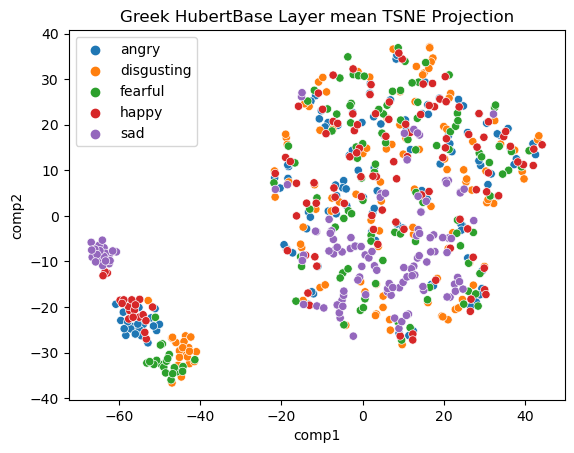

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(output, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=data['Label'].tolist(), data=df)
plt.title(f'Greek HubertBase Layer {layer} TSNE Projection')
plt.savefig(f'emotiondata/images/HubertBase_TSNE_{layer}')
plt.show()


CNN

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [21]:
model = ICASSP3CNN(768, bidirectional=True)

In [22]:
import torch.optim as optim

try:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)
except:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)

In [23]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()
    

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  3%|█████                                                                                                                                                    | 1/30 [00:06<02:58,  6.15s/it]

epoch:1, train accu:0.2733, train loss:1.67, valid accu:0.3636, valid loss:1.76


  7%|██████████▏                                                                                                                                              | 2/30 [00:11<02:42,  5.81s/it]

epoch:2, train accu:0.5321, train loss:1.20, valid accu:0.5455, valid loss:1.43


 10%|███████████████▎                                                                                                                                         | 3/30 [00:17<02:34,  5.73s/it]

epoch:3, train accu:0.6439, train loss:0.98, valid accu:0.6116, valid loss:1.09


 13%|████████████████████▍                                                                                                                                    | 4/30 [00:23<02:28,  5.72s/it]

epoch:4, train accu:0.7226, train loss:0.71, valid accu:0.6612, valid loss:0.94


 17%|█████████████████████████▌                                                                                                                               | 5/30 [00:28<02:21,  5.68s/it]

epoch:5, train accu:0.7826, train loss:0.54, valid accu:0.6777, valid loss:0.74


 20%|██████████████████████████████▌                                                                                                                          | 6/30 [00:34<02:15,  5.63s/it]

epoch:6, train accu:0.8530, train loss:0.38, valid accu:0.6694, valid loss:0.93


 23%|███████████████████████████████████▋                                                                                                                     | 7/30 [00:39<02:08,  5.59s/it]

epoch:7, train accu:0.8592, train loss:0.38, valid accu:0.7521, valid loss:0.78


 27%|████████████████████████████████████████▊                                                                                                                | 8/30 [00:45<02:02,  5.58s/it]

epoch:8, train accu:0.9193, train loss:0.28, valid accu:0.6860, valid loss:0.88


 30%|█████████████████████████████████████████████▉                                                                                                           | 9/30 [00:50<01:56,  5.57s/it]

epoch:9, train accu:0.9234, train loss:0.23, valid accu:0.7521, valid loss:0.71


 33%|██████████████████████████████████████████████████▋                                                                                                     | 10/30 [00:56<01:51,  5.56s/it]

epoch:10, train accu:0.9337, train loss:0.18, valid accu:0.7355, valid loss:0.94


 37%|███████████████████████████████████████████████████████▋                                                                                                | 11/30 [01:01<01:45,  5.57s/it]

epoch:11, train accu:0.8923, train loss:0.31, valid accu:0.7273, valid loss:0.90


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 12/30 [01:07<01:40,  5.57s/it]

epoch:12, train accu:0.9234, train loss:0.26, valid accu:0.6942, valid loss:0.95


 43%|█████████████████████████████████████████████████████████████████▊                                                                                      | 13/30 [01:13<01:34,  5.58s/it]

epoch:13, train accu:0.9172, train loss:0.27, valid accu:0.7521, valid loss:0.98


 47%|██████████████████████████████████████████████████████████████████████▉                                                                                 | 14/30 [01:18<01:29,  5.59s/it]

epoch:14, train accu:0.9420, train loss:0.16, valid accu:0.6942, valid loss:0.98


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 15/30 [01:24<01:24,  5.66s/it]

epoch:15, train accu:0.9503, train loss:0.11, valid accu:0.7686, valid loss:0.80


 53%|█████████████████████████████████████████████████████████████████████████████████                                                                       | 16/30 [01:30<01:19,  5.65s/it]

epoch:16, train accu:0.9731, train loss:0.08, valid accu:0.7521, valid loss:0.95


 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 17/30 [01:35<01:13,  5.63s/it]

epoch:17, train accu:0.9938, train loss:0.03, valid accu:0.7521, valid loss:0.94


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 18/30 [01:41<01:07,  5.61s/it]

epoch:18, train accu:0.9979, train loss:0.02, valid accu:0.7603, valid loss:1.02


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 19/30 [01:46<01:01,  5.60s/it]

epoch:19, train accu:1.0000, train loss:0.01, valid accu:0.7355, valid loss:1.08


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 20/30 [01:52<00:56,  5.60s/it]

epoch:20, train accu:1.0000, train loss:0.01, valid accu:0.7355, valid loss:1.11


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 21/30 [01:58<00:50,  5.59s/it]

epoch:21, train accu:0.9979, train loss:0.01, valid accu:0.7686, valid loss:1.14


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22/30 [02:03<00:44,  5.61s/it]

epoch:22, train accu:0.9959, train loss:0.02, valid accu:0.7603, valid loss:1.10


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23/30 [02:09<00:39,  5.59s/it]

epoch:23, train accu:0.9938, train loss:0.02, valid accu:0.7273, valid loss:1.18


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24/30 [02:14<00:33,  5.60s/it]

epoch:24, train accu:0.9896, train loss:0.03, valid accu:0.7521, valid loss:1.26


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25/30 [02:20<00:27,  5.59s/it]

epoch:25, train accu:0.9938, train loss:0.03, valid accu:0.7355, valid loss:1.27


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26/30 [02:26<00:22,  5.63s/it]

epoch:26, train accu:0.9689, train loss:0.09, valid accu:0.7521, valid loss:0.99


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27/30 [02:31<00:16,  5.60s/it]

epoch:27, train accu:0.9669, train loss:0.10, valid accu:0.7107, valid loss:1.19


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28/30 [02:37<00:11,  5.59s/it]

epoch:28, train accu:0.9752, train loss:0.07, valid accu:0.7851, valid loss:0.98


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29/30 [02:42<00:05,  5.60s/it]

epoch:29, train accu:0.9772, train loss:0.08, valid accu:0.7934, valid loss:0.98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:48<00:00,  5.62s/it]

epoch:30, train accu:0.9896, train loss:0.04, valid accu:0.8017, valid loss:0.87


In [24]:
# os.makedirs("emotiondata/models")
layer

'mean'

In [25]:
# model_path = f'emotiondata/models/hubertcbase_{layer}.pth'

# torch.save({'epoch':epochs,
#             'model_state_dict':model.state_dict(),
#             'optimizer_state_dict':optimizer.state_dict()},
#             model_path)

In [26]:
#os.makedirs("emotiondata/results")

In [27]:
import pandas as pd

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 'valid loss':valid_losses, 'train accu':train_accuracies, 'valid_accu':valid_accuracies})
metadata.to_csv(f'emotiondata/results/hubertbase_{layer}.csv', index=False)

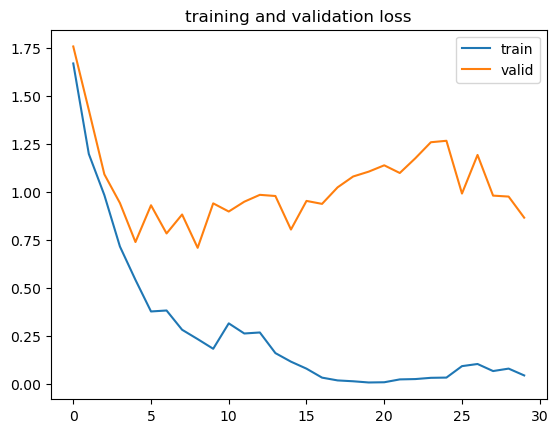

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

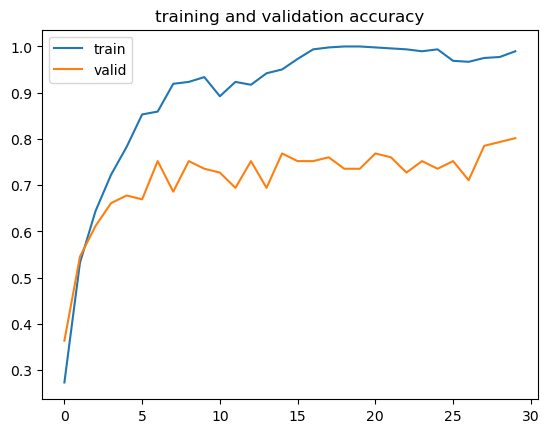

In [29]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []


for inputs, lengths, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs, lengths) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


In [31]:
#os.makedirs("emotiondata/images")

In [32]:
classes = list(data['Label'].unique())
classes

['angry', 'disgusting', 'fearful', 'happy', 'sad']

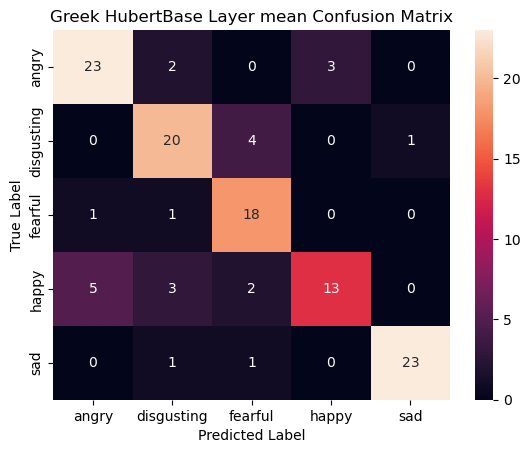

In [33]:
import numpy as np
cf = confusion_matrix(y_true, y_pred)
classes = list(data['Label'].unique())
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                     columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Greek HubertBase Layer {layer} Confusion Matrix')
plt.savefig(f'emotiondata/images/HubertBase_CM_{layer}')
plt.show()

In [34]:
accus = list(cf.diagonal()/cf.sum(axis=1))
res = pd.DataFrame({'class':classes, 'accuracy':accus})
res

,class,accuracy
0,angry,0.821429
1,disgusting,0.800000
2,fearful,0.900000
3,happy,0.565217
4,sad,0.920000


In [35]:
res.to_csv(f'emotiondata/results/hubertbase_perclass_{layer}.csv', index=False)